In this script I try some of the possible ways of correlating the segmentation with the nodes communities

- By using the communities COM and the segmentation
- By using the correlation between the parcellation and the community of provenience


In [21]:
import nibabel as nib
import numpy as np
import networkx as nx
from skimage.measure import marching_cubes
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm
import networkx as nx
import os
import numpy as np
from glob import glob
import nibabel as nib
import nibabel.freesurfer.mghformat as mghf # read mgz images
from skimage.morphology import skeletonize_3d
from skimage.measure import marching_cubes
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors




In [5]:

def rescale_coordinates(node_positions, skeleton_coords):
    graph_min = node_positions.min(axis=0)
    graph_max = node_positions.max(axis=0)
    skeleton_min = skeleton_coords.min(axis=0)
    skeleton_max = skeleton_coords.max(axis=0)

    normalized_node_positions = (
        (node_positions - graph_min) / (graph_max - graph_min)
    ) * (skeleton_max - skeleton_min) + skeleton_min

    return normalized_node_positions

In [15]:
# Path to the main directory containing the folders with data
main_directory = "PR-graphomics/sequences/"

# List all subfolders inside the main directory
folders = [f for f in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, f))]
folder = folders[10]

print(f"Accessing folder: {folder}")
folder_path = os.path.join(main_directory, folder)
    
#In this way I add to the address the folder inside the first one
folder_path = os.path.join(folder_path, os.listdir(folder_path)[0])
#aparc.DKTatlas+aseg.deep.mgz aparc.DKTatlas+aseg.deep.nii.gz
image_path = os.path.join(folder_path, 'aparc.DKTatlas+aseg.deep.mgz')
graph_path = os.path.join(folder_path, 'sk-graph.pickle')
vol = mghf.load(image_path)

volume = vol.get_fdata()
volume = volume != 0
verts, faces, normals, values = marching_cubes(volume, 0)

ptx, pty, ptz = verts.T
skeleton = skeletonize_3d(volume)
graph = nx.read_gpickle(graph_path)

df = pd.read_csv('PR-graphomics/labelmap.csv', sep = ',')
df[0:10]


print('Number of nodes in he graph: ', str(len(graph.nodes())))

Accessing folder: 54373


/tmp/ipykernel_5211/4289965036.py:23: FutureWarning: `skeletonize_3d` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.morphology.skeletonize` instead.
  skeleton = skeletonize_3d(volume)


Number of nodes in he graph:  1073


Number of nodes in the graph:  1073
Number of edges in the graph:  1696


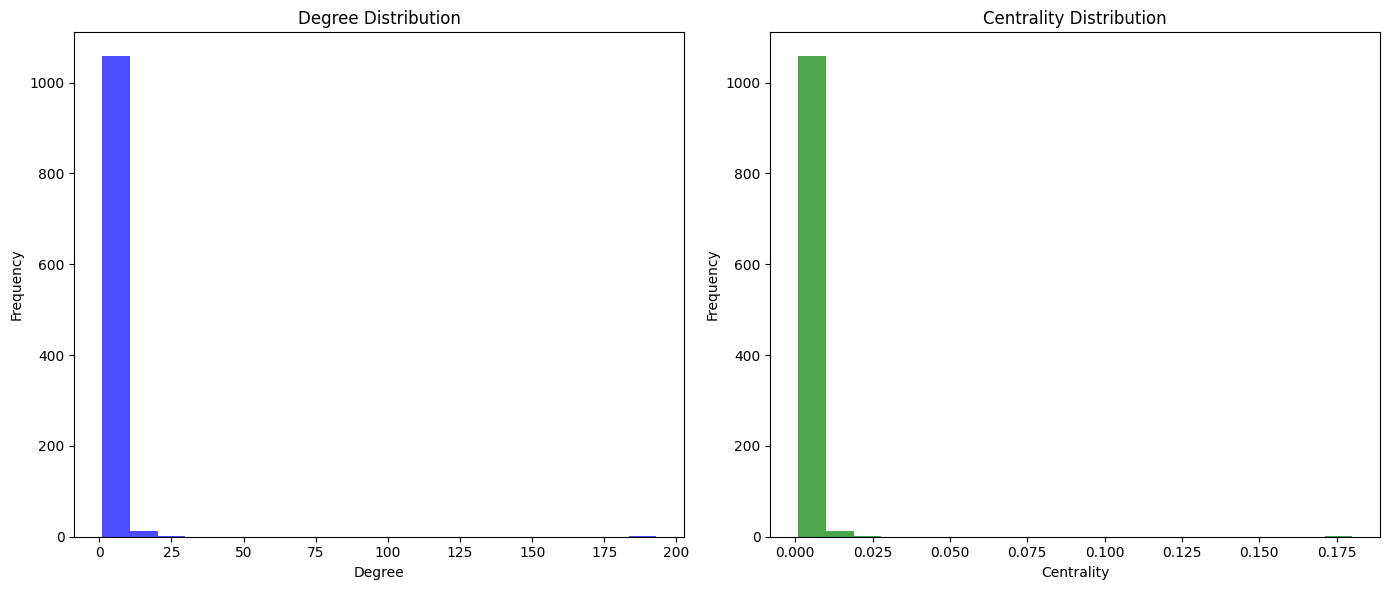

In [32]:

print('Number of nodes in the graph: ', str(len(graph.nodes())))

print('Number of edges in the graph: ', str(len(graph.edges())))



# Calculate degree and centrality
degree_dict = dict(graph.degree())
centrality_dict = nx.degree_centrality(graph)

# Degree distribution (histogram)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(degree_dict.values(), bins=20, color='blue', alpha=0.7)
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')

# Centrality distribution (histogram)
plt.subplot(1, 2, 2)
plt.hist(centrality_dict.values(), bins=20, color='green', alpha=0.7)
plt.title('Centrality Distribution')
plt.xlabel('Centrality')
plt.ylabel('Frequency')

# Show both histograms
plt.tight_layout()
plt.show()


Found 65 Louvain communities


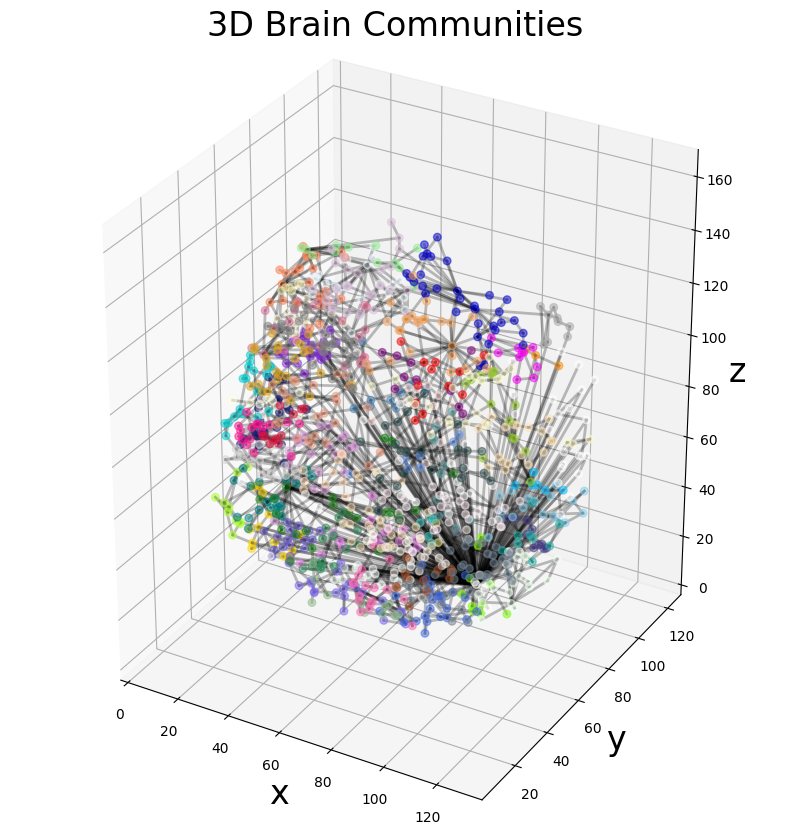

In [27]:


community = list(nx.community.louvain_communities(graph, seed=42, resolution=5))

print('Found {:d} Louvain communities'.format(len(community)))

#print('Number of nodes in he graph: ', str(len(graph.nodes())))


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

colors = list(mcolors.CSS4_COLORS.keys())
np.random.shuffle(colors)
# draw the skeleton shape
#sx, sy, sz = np.where(skeleton)
#ax.scatter(sx, sy, sz, color='r', marker='o', s=10, alpha=0.15)

# plot the nodes as blue dots
for com, color in zip(community, colors):
    ax.scatter(*zip(*com), color=color, marker='o', s=30, alpha=0.5)
    
# plot the edges as lines between vertices
for ex, ey in graph.edges():
    ax.plot(*zip(*(ex, ey)), color='k', linewidth=2, alpha=0.25)
    
ax.set_box_aspect((np.ptp(ptx), np.ptp(pty), np.ptp(ptz)))
ax.set_xlabel('x', fontsize=24)
ax.set_ylabel('y', fontsize=24)
ax.set_zlabel('z', fontsize=24)
_ = ax.set_title('3D Brain Communities', fontsize=24)
